In [1]:
#packages
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing,metrics 
from haversine import haversine
from datetime import datetime
import xgboost as xgb
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import warnings
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split,KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression,Lasso,LinearRegression, Ridge,BayesianRidge
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans 
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", 100)
%matplotlib inline

In [2]:
#loading data 
train_data = pd.read_csv('train.csv')
train_data.sample(5)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
1418491,id2529104,1,2016-01-26 15:12:36,2016-01-26 15:26:27,1,-73.969788,40.750618,-73.961632,40.760670,N,831
712984,id1194364,2,2016-05-11 03:59:03,2016-05-11 04:04:54,1,-73.987999,40.764629,-73.980827,40.764130,N,351
791256,id3329014,2,2016-03-01 10:03:40,2016-03-01 10:46:52,1,-73.862770,40.768806,-73.982536,40.755322,N,2592
743891,id1346292,1,2016-03-25 09:07:38,2016-03-25 09:15:07,1,-73.995758,40.754082,-73.989792,40.767563,N,449
214554,id3752818,1,2016-03-22 08:59:07,2016-03-22 09:22:57,1,-73.960640,40.769745,-73.987015,40.744709,N,1430


In [3]:
#check for missing column values and check data shape
missing_train = train_data.isnull().mean().sort_values(ascending=False)
print(missing_train.head(5))
print(train_data.shape)

trip_duration         0.0
store_and_fwd_flag    0.0
dropoff_latitude      0.0
dropoff_longitude     0.0
pickup_latitude       0.0
dtype: float64
(1458644, 11)


In [4]:
#drop uneceessary features and add haversine distance 
train_data.drop(labels=['id','pickup_datetime','dropoff_datetime'], axis=1, inplace=True)
train_dist = []
for index, row in train_data.iterrows():
    dist_train = haversine([row['pickup_latitude'],row['pickup_longitude']],[row['dropoff_latitude'],row['dropoff_longitude']])
    train_dist.append(dist_train)
train_data['dist'] = train_dist

In [ ]:
#analyze and remove outliers
max_dist_train = np.max([train_data['dist']])
print("Max_dist", max_dist_train)
min_dist_train = np.min([train_data['dist']])
print("Min_dist",min_dist_train)
mean_dist_train = np.mean([train_data['dist']])
print("Mean_dist",mean_dist_train)
dist_std_train = np.std(train_data['dist'])
train_data = train_data[train_data['dist'] <= mean_dist_train + 2*dist_std_train]
train_data = train_data[train_data['dist'] >= mean_dist_train - 2*dist_std_train]

Max_dist 1240.9103906669181
Min_dist 0.0
Mean_dist 3.440868654734528


In [ ]:
#encoding necessary features and randomly sample to reduce dataset size
train_data = train_data.replace({"store_and_fwd_flag": {"N":0, "Y":1}})
train_data = train_data.sample(frac=0.1,random_state=4)
#train_data.sample(5)

In [ ]:
#transforming duration to log scale to allow for RMSE plus spliting data
train_data['log_duration'] = np.log(train_data['trip_duration'].values + 1)
train_data.drop(labels=['trip_duration'], axis=1, inplace=True)
train_target = pd.DataFrame(train_data['log_duration'])
train_data.drop('log_duration', axis = 1, inplace = True)
X_train, X_test, y_train, y_test = train_test_split(np.array(train_data), np.array(train_target), test_size=0.30)
eval_set=[(X_test, y_test)]
print("train_target: ", train_target.shape)
print('train_set: ', X_train.shape, y_train.shape)
print('test_set: ', X_test.shape, y_test.shape)

train_target:  (139495, 1)
train_set:  (97646, 8) (97646, 1)
test_set:  (41849, 8) (41849, 1)


In [ ]:
#Random Forest
random_forest_regressor= RandomForestRegressor(n_estimators = 100, n_jobs = 4)
random_forest_regressor.fit(X_train, y_train)
rf_y_pred = random_forest_regressor.predict(X_test)
random_forest_error =  np.sqrt(mean_squared_error(y_test, rf_y_pred))
print("Test error: ", random_forest_error)
print(y_test[0:10])
print(rf_y_pred[0:10])

Test error:  0.4740858788450759
[[6.52649486]
 [5.67332327]
 [5.66296048]
 [6.20253552]
 [7.1491316 ]
 [6.55961524]
 [6.2441669 ]
 [5.12396398]
 [6.45990445]
 [7.85554468]]
[5.96627376 5.87121493 6.1773009  5.76117761 7.24784922 6.71962444
 5.80639109 5.47822255 6.4351085  4.9904701 ]


                    Importance
dist                  0.629201
dropoff_latitude      0.095163
dropoff_longitude     0.086241
pickup_longitude      0.085299
pickup_latitude       0.077380
passenger_count       0.015137
vendor_id             0.010943
store_and_fwd_flag    0.000637


Text(0, 0.5, 'Normalized Gini Importance')

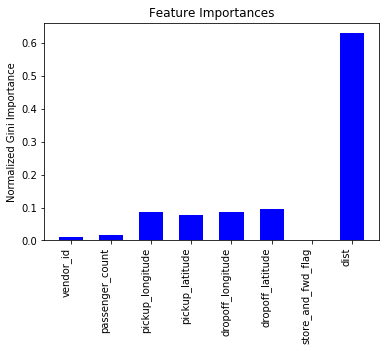

In [ ]:
#Feature importance
fig, ax = plt.subplots()
width = 0.6
feature_importances = pd.DataFrame(random_forest_regressor.feature_importances_, index = train_data.columns, columns = ['Importance']).sort_values('Importance', ascending = False)
print(feature_importances)
ax.bar(np.arange(len(train_data.columns)), random_forest_regressor.feature_importances_, width, color='b')
ax.set_xticks(np.arange(len(random_forest_regressor.feature_importances_)))
ax.set_xticklabels(train_data.columns.values, rotation = 90, horizontalalignment='right')
plt.title('Feature Importances')
ax.set_ylabel('Normalized Gini Importance')

In [ ]:
#XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtrain.save_binary('train.buffer')
dtest = xgb.DMatrix(X_test, label=y_test)
dtest.save_binary('test.buffer')
evallist = [(dtest, 'eval'), (dtrain, 'train')]
param = {'min_child_weight': 3, 'eta': 0.9, 'colsample_bytree': 0.6, 'max_depth': 6,
            'subsample': 0.9, 'lambda': 1., 'nthread': -1,'booster' : 'gbtree',
            'eval_metric': 'rmse', 'objective': 'reg:linear'}
bst = xgb.train(param, dtrain, 10, evallist, early_stopping_rounds=2, maximize=False, verbose_eval=1)
print('Modeling RMSLE %.5f' % bst.best_score)
pred = bst.predict(dtest, ntree_limit=bst.best_ntree_limit)
pred = np.exp(pred) - 1

[04:14:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=6
[0]	eval-rmse:0.899456	train-rmse:0.891365
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 2 rounds.
[04:14:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[1]	eval-rmse:0.677491	train-rmse:0.664235
[04:14:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[2]	eval-rmse:0.671255	train-rmse:0.656483
[04:14:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[3]	eval-rmse:0.616563	train-rmse:0.599849
[04:14:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[4]	eval-rmse:0.614163	train-rmse:0.59593
[04:14:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra n

In [ ]:
#Multi-layer perceptron
multi_layer_perceptron_regressor = MLPRegressor(solver='lbfgs', alpha = 1e-5, hidden_layer_sizes = (5, 2), random_state = 1)
multi_layer_perceptron_regressor.fit(X_train, y_train)     
mlp_y_pred = multi_layer_perceptron_regressor.predict(X_test)
mlp_error = np.sqrt(mean_squared_error(y_test, mlp_y_pred))
print("Test error: ", mlp_error)

Test error:  0.7609116100313128


In [ ]:
#Multi-layer perceptron with Adam solver + changed hyperparams
multi_layer_perceptron_regressor_2 = MLPRegressor(hidden_layer_sizes=(200,), activation='relu', solver='adam', alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum = True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08,n_iter_no_change = 10)
multi_layer_perceptron_regressor_2.fit(X_train, y_train)     
mlp_y_pred_2 = multi_layer_perceptron_regressor_2.predict(X_test)
mlp_error_2 = np.sqrt(mean_squared_error(y_test, mlp_y_pred_2))
print("Test error: ", mlp_error_2)

Test error:  0.5197200030740071


In [ ]:
#svm using various kernels
#commented out since it takes very long to run

# kernels = ['linear','sigmoid','rbf']
# for curr_kernel in kernels:
#     model_svm = SVR(kernel= curr_kernel)
#     model_svm.fit(X_train, y_train)
#     svm_pred = model_svm.predict(X_test)
#     svm_pred_error = np.sqrt(mean_squared_error(y_test, svm_pred))
#     print(curr_kernel)
#     print("Test error: ", svm_pred_error)`